# exp007

In [47]:
MODE = 'local_train'
#MODE = 'kaggle_inference'

In [48]:
exp_name = 'exp007'
memo = 'ペア間距離stats特徴量追加'

In [49]:
import os
import sys
import gc

if MODE == 'local_train':
    sys.path.append('/home/kaggler/.local/lib/python3.8/site-packages')
    from dotenv import load_dotenv
    load_dotenv
    sys.path.append(os.getenv('UTILS_PATH'))
    import line_notify
    import slack_notify
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("ggplot")
import seaborn as sns
from sklearn.metrics.pairwise import haversine_distances
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import itertools
from tqdm import tqdm
from scipy.spatial.distance import canberra
from sklearn.neighbors import KNeighborsRegressor
import multiprocessing
import Levenshtein
import difflib
import pickle
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [50]:
# directry_setting
if MODE == 'local_train':
    INPUT_DIR = os.getenv('INPUT_DIR')
    OUTPUT_DIR = os.getenv('OUTPUT_DIR')
    MODEL_DIR = os.getenv('OUTPUT_DIR')
    os.makedirs(OUTPUT_DIR + exp_name, exist_ok=True)

elif MODE == 'kaggle_inference':
    INPUT_DIR = '/kaggle/input/foursquare-location-matching/'
    OUTPUT_DIR = './'
    MODEL_DIR = f'../input/fs{exp_name}/'

In [51]:
# CONFIG
SEED = 42
N_NEIGHBORS = 10
N_SPLITS = 5
PROB_TH = 0.5

In [52]:
def preprocess(df):
    columns = ['id', 'name', 'address', 'city', 'state',
        'zip', 'country', 'url', 'phone', 'categories']
    for c in columns:
        if c != "id":
            df[c] = df[c].astype(str).str.lower()
    return df

In [53]:
def extract_candidate(df):
    dfs = []
    candidates = pd.DataFrame()
    for country, country_df in tqdm(df.groupby("country")):
        country_df = country_df.reset_index(drop=True)
        
        knn = KNeighborsRegressor(n_neighbors=min(len(country_df), N_NEIGHBORS), 
                                  metric='haversine', n_jobs=-1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude','longitude']], return_distance=True)
        
        k = min(len(country_df), N_NEIGHBORS)
        country_df['match_id'] = country_df['id'].values[nears[:, :k]].tolist()
        country_df['d_near'] = dists[:, :k].tolist()
        dfs.append(country_df[['id','match_id','d_near']])
    df = pd.concat(dfs).reset_index(drop=True)
    return df

In [54]:
def add_orgin_data(df, org_df):
    df = df.explode(['match_id','d_near'])
    df = df.loc[df['id'] != df['match_id']].copy()
    df = df.merge(org_df, on='id')
    df = df.merge(org_df.add_prefix('match_'), on='match_id')
    df = df.reset_index(drop=True)
    return df

In [55]:
# https://www.kaggle.com/code/columbia2131/foursquare-iou-metrics
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame, org_data):
    scores = []
    id2poi = get_id2poi(org_data)
    poi2ids = get_poi2ids(org_data)
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def calc_max_score(tr_data, org_data):
    train_candidate = pd.DataFrame()
    train_candidate['id'] = org_data['id'].unique()
    train_candidate['matches'] = org_data['id'].unique()
    idx = tr_data['point_of_interest']==tr_data['match_point_of_interest']
    train_match = tr_data.loc[idx].groupby('id')['match_id'].apply(list).map(" ".join).reset_index()
    train_match.columns = ['id','candidates']
    train_candidate = train_candidate.merge(train_match, on = 'id', how = 'left')
    idx = ~train_candidate['candidates'].isna()
    train_candidate.loc[idx, "matches"] += " " + train_candidate.loc[idx, "candidates"]
    score = get_score(train_candidate, org_data)
    print('1st_stage_max_score : ' + '{:.5f}'.format(score))
    return score

In [56]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [57]:
def _add_distance_features(args):
    _, df = args

    columns = ['name', 'address', 'city', 'state',
               'zip', 'country', 'url', 'phone', 'categories']

    for c in columns:
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for str1, str2 in df[[f"{c}", f"match_{c}"]].values.astype(str):
            if str1==str1 and str2==str2:
                geshs.append(difflib.SequenceMatcher(None, str1, str2).ratio())
                levens.append(Levenshtein.distance(str1, str2))
                jaros.append(Levenshtein.jaro_winkler(str1, str2))
                lcss.append(LCS(str(str1), str(str2)))
            else:
                geshs.append(-1)
                levens.append(-1)
                jaros.append(-1)
        df[f"match_{c}_gesh"] = geshs
        df[f"match_{c}_leven"] = levens
        df[f"match_{c}_jaro"] = jaros
        df[f"match_{c}_lcs"] = lcss
            
        if not c in ['country', "phone", "zip"]:
            df[f"match_{c}_len"] = df[f"match_{c}"].astype(str).map(len)
            df[f"match_{c}_nleven"] = df[f"match_{c}_leven"] / df[f"match_{c}_len"]
            df[f"match_{c}_nlcsi"] = df[f"match_{c}_lcs"] / df[f"match_{c}_len"]
    return df


def add_distance_features(df):
    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(_add_distance_features, df.groupby('country'))
        dfs = tqdm(dfs)
        dfs = list(dfs)
    df = pd.concat(dfs)
    return df

In [58]:
def reduce_data_size(df, features):
    if MODE == 'local_train':
        df = df[features + ['target', 'id', 'match_id']].copy()
    elif MODE == 'kaggle_inference':
        df = df[features + ['id', 'match_id']].copy()


    df[features] = df[features].astype(np.float16)
    for _ in range(5):
        gc.collect()
        
    return df

In [59]:
def train_model(df, features):
    params = {'objective': 'binary', 
              'boosting': 'gbdt',
              'learning_rate': 0.1, 
              'metric': 'binary_logloss', 
              'seed': SEED, 
              'feature_pre_filter': False, 
              'lambda_l1': 0.5745709668124809, 
              'lambda_l2': 0.5123383865042099, 
              'num_leaves': 239, 
              'feature_fraction': 0.784, 
              'bagging_fraction': 1.0, 
              'bagging_freq': 0, 
              'min_child_samples': 5
              }

    # split folds
    kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    for i, (trn_idx, val_idx) in enumerate(kf.split(df, df["target"], df["target"])):
        df.loc[val_idx, "fold"] = i
    
    fi = pd.DataFrame()
    oof = df[['id', 'match_id', 'target']].copy()
    oof['prob'] = 0.0
    scores = []

    for i in range(N_SPLITS):
        print('fold : ' + str(i))
        tr_idx = df[df['fold'] != i].index
        vl_idx = df[df['fold'] == i].index
        tr_x, tr_y = df.loc[tr_idx, features], df.loc[tr_idx, 'target']
        vl_x, vl_y = df.loc[vl_idx, features], df.loc[vl_idx, 'target']
        tr_data = lgb.Dataset(tr_x, label=tr_y)
        vl_data = lgb.Dataset(vl_x, label=vl_y)

        model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                        num_boost_round=20000, early_stopping_rounds=100, verbose_eval=1000)

        # 特徴量重要度
        fi_tmp = pd.DataFrame()
        fi_tmp['feature'] = model.feature_name()
        fi_tmp['importance'] = model.feature_importance(importance_type='gain')
        fi_tmp['iter'] = i
        fi = fi.append(fi_tmp)

        pred = model.predict(vl_x, num_iteration=model.best_iteration)
        oof.loc[vl_idx, 'prob'] = pred

        score = accuracy_score((pred > PROB_TH).astype(int), vl_y)
        scores.append(score)
        print(f'fold{i} | accuracy = ' + '{:.5f}'.format(score))

        with open(OUTPUT_DIR + f'{exp_name}/model{i}.pickle', 'wb') as f:
            pickle.dump(model, f)
        
    oof.to_csv(OUTPUT_DIR + f'{exp_name}/{exp_name}_oof.csv', index=False)

    print('accuracy(mean) : ' + '{:.5f}'.format(np.mean(scores)))
    print(scores)

    fi_n = fi['feature'].nunique()
    order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
    plt.figure(figsize=(10, fi_n*0.2))
    sns.barplot(x="importance", y="feature", data=fi, order=order)
    plt.title(f"LGBM importance")
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR + f'{exp_name}/lgbm_importance.png')

    return oof, np.mean(scores)

In [60]:
def model_inference(df, features):
    pred = np.zeros(len(df))
    for i in range(N_SPLITS):
        with open(MODEL_DIR + f'model{i}.pickle', 'rb') as f:
            model = pickle.load(f)
        pred += model.predict(df[features], num_iteration=model.best_iteration) / N_SPLITS
    return pred

In [61]:
def transform_data(df, org_data):
    train_candidate = pd.DataFrame()
    train_candidate['id'] = org_data['id'].unique()
    train_candidate['matches'] = org_data['id'].unique()

    train_match = df[df['prob'] >= PROB_TH].copy()
    train_match = train_match.groupby('id')['match_id'].apply(list).map(" ".join).reset_index()
    train_match.columns = ['id','candidates']
    train_candidate = train_candidate.merge(train_match, on = 'id', how = 'left')
    idx = ~train_candidate['candidates'].isna()
    train_candidate.loc[idx, "matches"] += " " + train_candidate.loc[idx, "candidates"]
    return train_candidate[['id', 'matches']]


In [62]:
def postprocess(df):
    id2match = dict(zip(df["id"].values, df["matches"].str.split()))

    for match in tqdm(df["matches"]):
        match = match.split()
        if len(match) == 1:        
            continue

        base = match[0]
        for m in match[1:]:
            if not base in id2match[m]:
                id2match[m].append(base)
    df["matches"] = df["id"].map(id2match).map(" ".join)
    return df 

In [63]:
def add_categories_dist_features(df):
    categories_dist = pd.read_csv(OUTPUT_DIR + 'prep/distance_dist/distance_dist.csv')
    categories_dist = categories_dist[categories_dist['count'] > 100].copy()
    categories_dist['1sigma'] = categories_dist['mean'] + (categories_dist['std']*1)
    categories_dist['2sigma'] = categories_dist['mean'] + (categories_dist['std']*2)
    categories_dist['3sigma'] = categories_dist['mean'] + (categories_dist['std']*3)
    categories_dist = categories_dist[['categories', 'mean', 'median', 'std']].copy()

    df = df.merge(categories_dist, on='categories', how='left')
    return df

In [64]:
def run_train():
    train_origin = pd.read_csv(INPUT_DIR + "train.csv")
    train_origin = preprocess(train_origin)

    categories_dist = pd.read_csv(OUTPUT_DIR + 'prep/distance_dist/distance_dist.csv')
    categories_dist = categories_dist[categories_dist['count'] > 100].copy()
    categories_dist['1sigma'] = categories_dist['mean'] + (categories_dist['std']*1)
    categories_dist['2sigma'] = categories_dist['mean'] + (categories_dist['std']*2)
    categories_dist['3sigma'] = categories_dist['mean'] + (categories_dist['std']*3)

    # trainデータの分割
    kf = GroupKFold(n_splits=2)
    for i, (trn_idx, val_idx) in enumerate(kf.split(train_origin, train_origin['point_of_interest'], train_origin['point_of_interest'])):
        train_origin.loc[val_idx, "set"] = i

    # 1st stage
    train = pd.concat([
        extract_candidate(train_origin[train_origin["set"]==0]), 
        extract_candidate(train_origin[train_origin["set"]==1]), 
    ])
    train = add_orgin_data(train, train_origin)
    stage1_max_score = calc_max_score(train, train_origin)

    # 2nd stage
    # create target
    train['target'] = (train['point_of_interest'] == train['match_point_of_interest']).values.astype(int)
    train["target"] = train["target"].fillna(0)

    train = add_distance_features(train)
    train = add_categories_dist_features(train)

    not_use_cols = ['match_state_leven', 'address', 'categories', 'point_of_interest', 'match_address_leven',
                    'city', 'match_point_of_interest', 'match_name', 'match_categories_leven', 'match_longitude',
                    'target', 'match_city_leven', 'zip', 'match_categories', 'match_city', 'match_latitude',
                    'match_zip', 'match_url', 'id', 'match_set', 'country', 'match_state', 'match_address',
                    'match_name_leven', 'match_id', 'latitude', 'url', 'set', 'name', 'phone', 'longitude',
                    'match_url_leven', 'state', 'match_phone', 'match_country']
    features = [c for c in train.columns if c not in not_use_cols]
    with open(OUTPUT_DIR + f'{exp_name}/features.pickle', 'wb') as f:
        pickle.dump(features, f)

    train = reduce_data_size(train, features)

    oof, stage2_mean_accuracy = train_model(train, features)
    oof = transform_data(oof, train_origin)

    cv_score = get_score(oof, train_origin)
    print(f'cv_score = ' + '{:.5f}'.format(cv_score))

    oof = postprocess(oof)
    cv_score_after_pp = get_score(oof, train_origin)
    print(f'cv_score(after_pp) = ' + '{:.5f}'.format(cv_score_after_pp))


    report = f'{exp_name}\n'
    report += memo + '\n'
    report += 'stage1_max_score : ' + '{:.5f}'.format(stage1_max_score) + '\n'
    report += 'stage2_mean_accuracy : ' + '{:.5f}'.format(stage2_mean_accuracy) + '\n'
    report += 'cv_score : ' + '{:.5f}'.format(cv_score) + '\n'
    report += 'cv_score_after_pp : ' + '{:.5f}'.format(cv_score_after_pp) + '\n'
    print(report)
    line_notify.send(report)
    slack_notify.send(report)

In [65]:
def run_inference():
    test_origin = pd.read_csv(INPUT_DIR + "test.csv")
    
    if len(test_origin) == 5:
        test_origin = pd.read_csv(INPUT_DIR + "train.csv")
        kf = GroupKFold(n_splits=2)
        for i, (trn_idx, val_idx) in enumerate(kf.split(test_origin, test_origin['point_of_interest'], test_origin['point_of_interest'])):
            test_origin = test_origin.loc[trn_idx]
            break

    test_origin = preprocess(test_origin)

    # 1st stage
    test = extract_candidate(test_origin)

    # 2nd stage
    test = add_orgin_data(test, test_origin)
    test = add_distance_features(test)
    with open(MODEL_DIR + 'features.pickle', 'rb') as f:
        features = pickle.load(f)
    test = reduce_data_size(test, features)
    
    print('test_dataset_info')
    print(test.info())
    
    test['prob'] = model_inference(test, features)
    test = transform_data(test, test_origin)
    test = postprocess(test)
    test.to_csv('submission.csv', index=False)

100%|██████████| 211/211 [00:56<00:00,  3.74it/s]


1st_stage_max_score : 0.89040


213it [13:58,  3.94s/it] 


fold : 0


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 571996, number of negative: 7626894
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.373776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7240
[LightGBM] [Info] Number of data points in the train set: 8198890, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069765 -> initscore=-2.590304
[LightGBM] [Info] Start training from score -2.590304
Training until validation scores don't improve for 100 rounds
[1000]	training's binary_logloss: 0.0536283	valid_1's binary_logloss: 0.0692272
[2000]	training's binary_logloss: 0.0409069	valid_1's binary_logloss: 0.0654508
[3000]	training's binary_logloss: 0.032386	valid_1's binary_logloss: 0.0631921
[4000]	training's binary_logloss: 0.0259027	valid_1's binary_logloss: 0.0615938
[5000]	training's binary_logloss: 0.0210273	valid_1's binary_logloss: 0.0605792
[6000]	training's binary_logloss: 0.0

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 571996, number of negative: 7626894
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.525777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7249
[LightGBM] [Info] Number of data points in the train set: 8198890, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069765 -> initscore=-2.590304
[LightGBM] [Info] Start training from score -2.590304
Training until validation scores don't improve for 100 rounds
[1000]	training's binary_logloss: 0.0538305	valid_1's binary_logloss: 0.0684227
[2000]	training's binary_logloss: 0.041555	valid_1's binary_logloss: 0.0647949
[3000]	training's binary_logloss: 0.0326454	valid_1's binary_logloss: 0.062471
[4000]	training's binary_logloss: 0.0260889	valid_1's binary_logloss: 0.0608386
[5000]	training's binary_logloss: 0.0212188	valid_1's binary_logloss: 0.05971
[6000]	training's binary_logloss: 0.0173

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 571996, number of negative: 7626894
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.518755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7245
[LightGBM] [Info] Number of data points in the train set: 8198890, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069765 -> initscore=-2.590304
[LightGBM] [Info] Start training from score -2.590304
Training until validation scores don't improve for 100 rounds
[1000]	training's binary_logloss: 0.0535596	valid_1's binary_logloss: 0.0696331
[2000]	training's binary_logloss: 0.0410476	valid_1's binary_logloss: 0.065853
[3000]	training's binary_logloss: 0.0325004	valid_1's binary_logloss: 0.063658
[4000]	training's binary_logloss: 0.0260745	valid_1's binary_logloss: 0.0620091
[5000]	training's binary_logloss: 0.0211075	valid_1's binary_logloss: 0.0610232
[6000]	training's binary_logloss: 0.01

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 571996, number of negative: 7626895
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.516653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7250
[LightGBM] [Info] Number of data points in the train set: 8198891, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069765 -> initscore=-2.590304
[LightGBM] [Info] Start training from score -2.590304
Training until validation scores don't improve for 100 rounds
[1000]	training's binary_logloss: 0.0537836	valid_1's binary_logloss: 0.0686668
[2000]	training's binary_logloss: 0.0413268	valid_1's binary_logloss: 0.0651006
[3000]	training's binary_logloss: 0.0325823	valid_1's binary_logloss: 0.0627544
[4000]	training's binary_logloss: 0.0259803	valid_1's binary_logloss: 0.0610444
[5000]	training's binary_logloss: 0.0209584	valid_1'

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 571996, number of negative: 7626895
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.323201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7263
[LightGBM] [Info] Number of data points in the train set: 8198891, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069765 -> initscore=-2.590304
[LightGBM] [Info] Start training from score -2.590304
Training until validation scores don't improve for 100 rounds
[1000]	training's binary_logloss: 0.0537998	valid_1's binary_logloss: 0.0692929
[2000]	training's binary_logloss: 0.0412964	valid_1's binary_logloss: 0.0656683
[3000]	training's binary_logloss: 0.0326783	valid_1's binary_logloss: 0.0633386
[4000]	training's binary_logloss: 0.0261301	valid_1's binary_logloss: 0.0617113
[5000]	training's binary_logloss: 0.0211644	valid_1'

100%|██████████| 1138812/1138812 [00:01<00:00, 1066340.67it/s]


cv_score(after_pp) = 0.83818
exp007
ペア間距離stats特徴量追加
stage1_max_score : 0.89040
stage2_mean_accuracy : 0.97928
cv_score : 0.83194
cv_score_after_pp : 0.83818



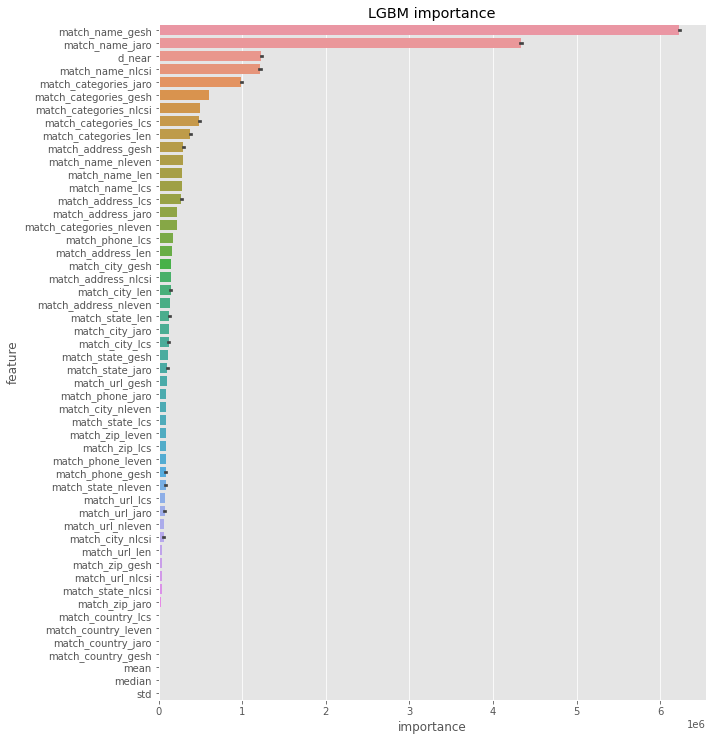

In [66]:
if MODE == 'local_train':
    run_train()
elif MODE == 'kaggle_inference':
    run_inference()